# Regressão Múltipla

Para esse estudo será usado um dataset do IBGE com informações de 66.470 indivíduos da população brasileira.
<br>
Pontos de estudos:

- Análise multivariada.
- Transformações nas distribuições para serem usadas em uma regressão.
- Tratamento de variáveis categóricas.
- O que seria afinal uma variável categórica?

Perguntas possíveis:

- Pessoas casadas ganham mais que pessoas solteiras?
- Existe diferença salarial entre as diferentes regiões do país?
- O salário aumenta com a idade?
- Vale a pena estudar mais para ganhar maiores salarios? Estudar até quando?

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Importando o dataset

In [2]:
caminho = 'C:\\Users\\Marcos\\Documents\\datascience_course\\Resumo_Aulas\\dados\\'
df = pd.read_csv(caminho + '/ibge_data.csv')

In [3]:
df.head()

,id,idade,sexo,anos_estudo,cor/raca,salario,estado_civil,regiao
0,1.100190e+10,53,homem,5.0,Parda,63600.000000,1.0,norte
1,1.100190e+10,49,mulher,8.0,Amarela,NaN,1.0,norte
2,1.100190e+10,22,mulher,11.0,Indigena,4352.400391,0.0,nordeste
3,1.100190e+10,55,homem,15.0,Amarela,96600.000000,1.0,norte
4,1.100190e+10,56,mulher,15.0,Amarela,157800.000000,1.0,norte


# Analisando os dados

In [4]:
df.describe()

,id,idade,anos_estudo,salario,estado_civil
count,6.647000e+04,66470.000000,66036.000000,47878.000000,66470.000000
mean,3.445307e+10,37.634813,8.686065,19706.790323,0.587724
std,1.292491e+10,11.380158,3.374522,88627.532024,0.492248
min,1.100190e+10,20.000000,5.000000,-1.000000,0.000000
25%,3.110060e+10,28.000000,5.000000,3780.000000,0.000000
50%,3.316781e+10,37.000000,8.000000,7113.599609,1.000000
75%,4.310361e+10,47.000000,11.000000,12720.000000,1.000000
max,5.311702e+10,60.000000,15.000000,999999.000000,1.000000


In [5]:
del df['id']

### Campos Nulos

In [6]:
df.isnull().sum().sort_values(ascending=False).head()

salario         18592
anos_estudo       434
cor/raca          242
regiao              0
estado_civil        0
dtype: int64

In [7]:
(df.isnull().sum() / df.isnull().count()).sort_values( ascending=False ).head(4)

salario        0.279705
anos_estudo    0.006529
cor/raca       0.003641
regiao         0.000000
dtype: float64

In [8]:
df['salario'].value_counts(dropna=False).nlargest(7)

 NaN         18592
 0.0          1841
-1.0          1101
 999999.0      367
 5229.0        277
 7200.0        260
 7560.0        244
Name: salario, dtype: int64

In [9]:
df['salario'].fillna(0, inplace=True)

In [10]:
df['salario']= df['salario'].replace(-1, 0) 

### Correlações com todas as variáveis

In [11]:
df.corr().round(4)

,idade,anos_estudo,salario,estado_civil
idade,1.0000,-0.2232,0.0954,0.2100
anos_estudo,-0.2232,1.0000,0.0964,-0.1188
salario,0.0954,0.0964,1.0000,0.0353
estado_civil,0.2100,-0.1188,0.0353,1.0000


### Média salarial por gênero

In [12]:
df.groupby(['sexo']).agg({'salario':'mean'})

,salario
sexo,
gestante,1271.102229
homem,19282.310466
mulher,9258.340413


In [13]:
df.corr()

,idade,anos_estudo,salario,estado_civil
idade,1.000000,-0.223166,0.095396,0.209986
anos_estudo,-0.223166,1.000000,0.096395,-0.118830
salario,0.095396,0.096395,1.000000,0.035284
estado_civil,0.209986,-0.118830,0.035284,1.000000


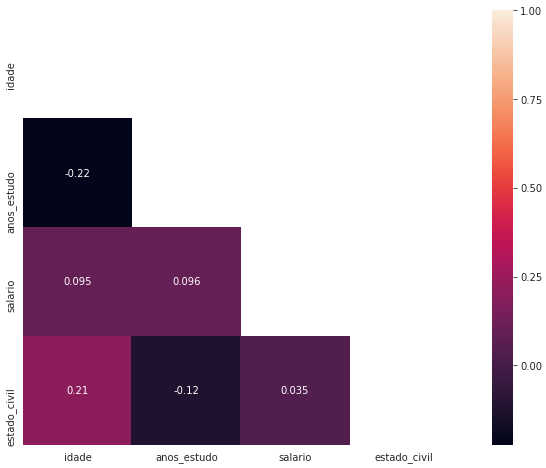

In [14]:
corr = df.corr()
mask = np.zeros_like(corr) # removendo valores zero
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(12, 8));
    
    sns.heatmap(
        corr,
        ax=ax,
        annot=True,
        mask=mask,
        square=True
    );

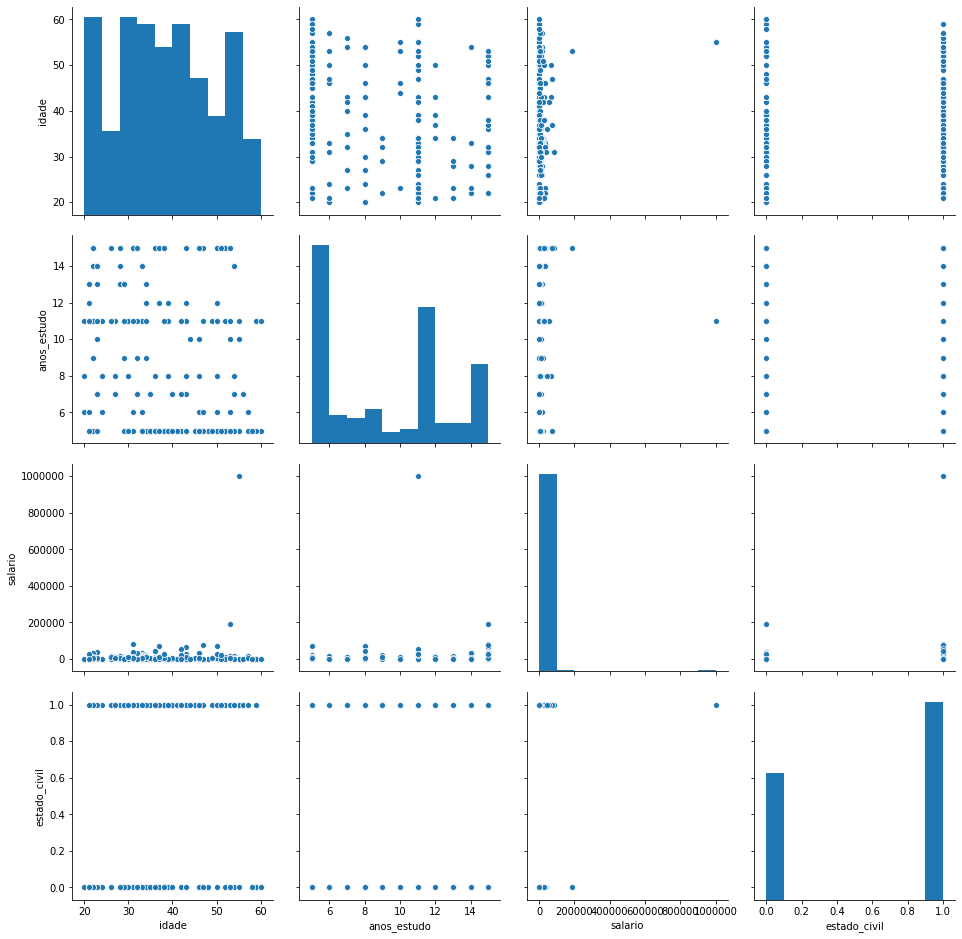

In [15]:
sns.pairplot(data=df.fillna(0).sample(200),size=3.3)

### Não é possível estimar as relações com estes gráficos

# Procurando uma relação entre idade e salário

Gráfico de dispersão entre idade e salário. Definindo um novo DataFrame 'temp' sem outliers para o salário e sample com 1000 observações.

In [16]:
df.head()

,idade,sexo,anos_estudo,cor/raca,salario,estado_civil,regiao
0,53,homem,5.0,Parda,63600.000000,1.0,norte
1,49,mulher,8.0,Amarela,0.000000,1.0,norte
2,22,mulher,11.0,Indigena,4352.400391,0.0,nordeste
3,55,homem,15.0,Amarela,96600.000000,1.0,norte
4,56,mulher,15.0,Amarela,157800.000000,1.0,norte


In [17]:
temp = df[(df.salario>0) & (df.salario<999999)]

In [18]:
temp.head()

,idade,sexo,anos_estudo,cor/raca,salario,estado_civil,regiao
0,53,homem,5.0,Parda,63600.000000,1.0,norte
2,22,mulher,11.0,Indigena,4352.400391,0.0,nordeste
3,55,homem,15.0,Amarela,96600.000000,1.0,norte
4,56,mulher,15.0,Amarela,157800.000000,1.0,norte
5,30,mulher,15.0,Amarela,88550.000000,0.0,nordeste


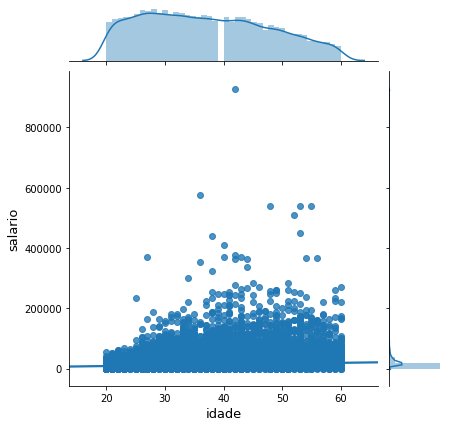

In [19]:
sns.jointplot(x="idade", y="salario", data=temp, kind='reg') # hue='estado_civil'
plt.ylabel('salario', fontsize=13)
plt.xlabel('idade', fontsize=13)
plt.show()

### Agrupando as pessoas por idade e plotando os salários por esses grupos

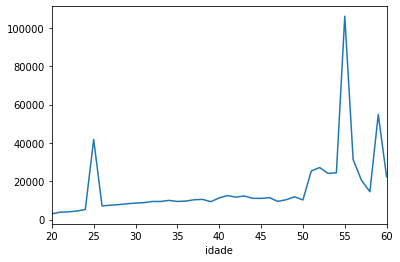

In [20]:
df.groupby('idade')['salario'].mean().plot()

A partir dos 35 anos a curva começa a apresentar uma variação maior.

### Verificando a quantidade de pessoas por idade

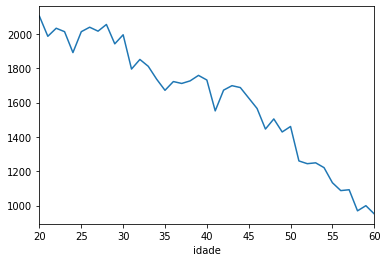

In [21]:
df.groupby('idade')['salario'].size().plot()

A partir dos 32 anos (em torno de) o número de observações cai bastante.

# Rodando a regressão

__Salário x Idade__

In [22]:
model = smf.ols('salario ~ idade', df).fit()
print(model.summary2())

                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.009       
Dependent Variable: salario          AIC:                1681611.8974
Date:               2019-06-24 10:34 BIC:                1681630.1065
No. Observations:   66470            Log-Likelihood:     -8.4080e+05 
Df Model:           1                F-statistic:        610.4       
Df Residuals:       66468            Prob (F-statistic): 3.63e-134   
R-squared:          0.009            Scale:              5.6839e+09  
---------------------------------------------------------------------
             Coef.     Std.Err.    t    P>|t|     [0.025     0.975]  
---------------------------------------------------------------------
Intercept  -9698.5962 1010.3080 -9.5996 0.0000 -11678.7997 -7718.3928
idade        634.8726   25.6960 24.7071 0.0000    584.5085   685.2367
---------------------------------------------------------------------
Omnibus:            113346.599     Durb

__Para cada ano de estudo há um aumento de 634,87 aos salários__

### Tirando os outliers e rodando a regressão por uma função

In [23]:
def run_regression(df,function):
    model = smf.ols(function, df).fit()
    print(model.summary2())
    return model 

In [24]:

mascara = df.salario < 999999
run_regression(df[mascara],'salario ~ idade')

                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.007       
Dependent Variable: salario          AIC:                1486172.3884
Date:               2019-06-24 10:34 BIC:                1486190.5863
No. Observations:   66103            Log-Likelihood:     -7.4308e+05 
Df Model:           1                F-statistic:        444.2       
Df Residuals:       66101            Prob (F-statistic): 2.75e-98    
R-squared:          0.007            Scale:              3.4011e+08  
----------------------------------------------------------------------
              Coef.    Std.Err.     t     P>|t|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept   3712.9389  248.2289  14.9577  0.0000  3226.4102  4199.4676
idade        133.3197    6.3255  21.0767  0.0000   120.9218   145.7176
---------------------------------------------------------------------
Omnibus:           103878.149     

__O R2 diminui para 0.007 e observamos pelo beta que o salário aumenta 133,31 por ano de estudo.__
<br>
__O beta é como um valor médio para uma distribuição normal formada com os resultados de Desvio-Padrão (std err), números de Desvios-Padrão até o zero (t), probabilidade de o coeficiente ser zero ou probabilidade de t (p>|t|), e o intervalo de confiança do Beta dentro do nível de significância de 95%. 
<br>
A melhor estratégia é estudar o comportamento da variável salário.__

# Plotando um histograma do salário

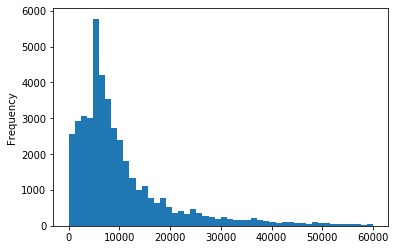

In [25]:
temp[temp.salario<60000].salario.plot.hist(bins=50)

__Normalizando com o LOG__

__Distribuição da variável Salario__

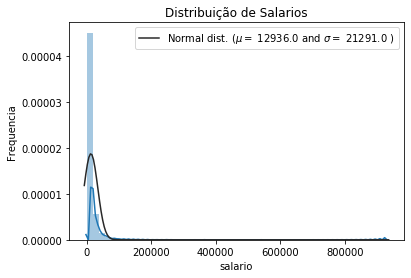

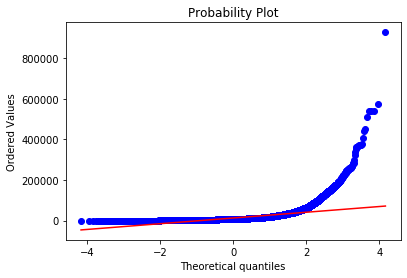

In [29]:
sns.distplot(temp['salario'].fillna(0), fit=stats.norm);

(mu, sigma) = stats.norm.fit(temp['salario'].fillna(0)) # para calcular a média e o desvio-padrão
plt.legend([f'Normal dist. ($\mu=$ {round(mu,0)} and $\sigma=$ {round(sigma,0)} )'],loc='best')
plt.ylabel('Frequencia')
plt.title('Distribuição de Salarios')

fig = plt.figure()
res = stats.probplot(temp['salario'], plot=plt)
plt.show()

__Existem excessos de outliers ou HETEROCEDASTICIDADE, visíviel pela Probability Plot. Necessário um tratamento com a função log__

__Normalizando e plotando__

In [34]:
temp['log_do_salario'] = np.log1p(temp['salario'])

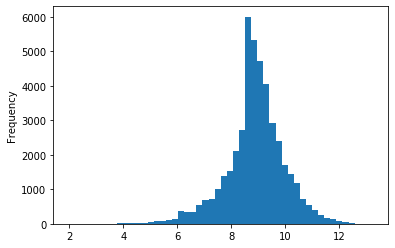

In [35]:
temp[temp.salario<600000].log_do_salario.plot.hist(bins=50)

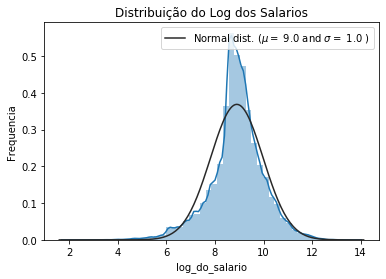

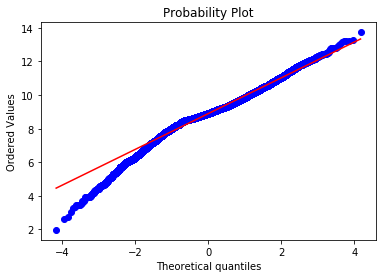

In [36]:
sns.distplot(temp['log_do_salario'].fillna(0), fit=stats.norm);

(mu, sigma) = stats.norm.fit(temp['log_do_salario'].fillna(0))
plt.legend([f'Normal dist. ($\mu=$ {round(mu,0)} and $\sigma=$ {round(sigma,0)} )'],loc='best')
plt.ylabel('Frequencia')
plt.title('Distribuição do Log dos Salarios')

fig = plt.figure()
res = stats.probplot(temp['log_do_salario'], plot=plt)
plt.show()

__Com a função LOG a variável salario agora apresenta uma distribuição mais normal.__

# 1 - Qual a relação entre Educação e Salário?

__Com a variável Salario__

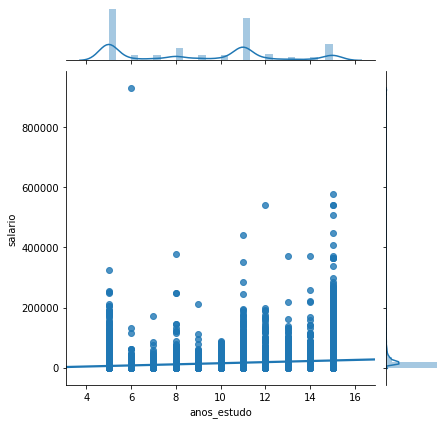

In [38]:
sns.jointplot(x="anos_estudo", y="salario", data=temp, kind='reg')

__Com a variável Log_do_salario__

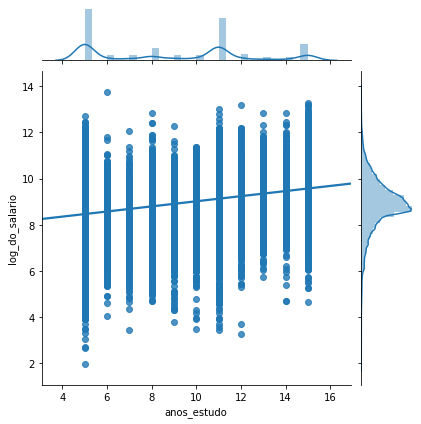

In [41]:
sns.jointplot(x="anos_estudo", y="log_do_salario", data=temp, kind='reg') # hue='estado_civil'

__Aparentemente há um aumento na curva do salário em relação à quantidade de anos de estudos. Mas será o fator anos de estudo ou por que as pessoas são mais velhas?__

### Rodando uma Regressão Simples - apenas com anos de estudo

__Com a variável salario - sem a função log.__

In [42]:
run_regression(temp,'salario ~ anos_estudo')

                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.086       
Dependent Variable: salario          AIC:                1003684.5069
Date:               2019-06-24 10:51 BIC:                1003701.9018
No. Observations:   44243            Log-Likelihood:     -5.0184e+05 
Df Model:           1                F-statistic:        4171.       
Df Residuals:       44241            Prob (F-statistic): 0.00        
R-squared:          0.086            Scale:              4.1667e+08  
---------------------------------------------------------------------
              Coef.    Std.Err.    t     P>|t|    [0.025     0.975]  
---------------------------------------------------------------------
Intercept   -3387.9726 271.1504 -12.4948 0.0000 -3919.4322 -2856.5130
anos_estudo  1825.5288  28.2652  64.5856 0.0000  1770.1285  1880.9292
---------------------------------------------------------------------
Omnibus:             67998.305     Durb

__Observações__
<br>
O R2 é de 0.086 e o beta é de 1825,52 reis a mais para cada ano de estudo.

Uma pessoa com 15 anos de estudos teria um salário de:

In [44]:
-3387.9726 + 15*1825.5288

23994.9594

__Com a variável log_do_salario - salario com a função log.__

In [43]:
run_regression(temp,'log_do_salario ~ anos_estudo')

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.124      
Dependent Variable: log_do_salario   AIC:                126631.3177
Date:               2019-06-24 10:53 BIC:                126648.7126
No. Observations:   44243            Log-Likelihood:     -63314.    
Df Model:           1                F-statistic:        6240.      
Df Residuals:       44241            Prob (F-statistic): 0.00       
R-squared:          0.124            Scale:              1.0246     
----------------------------------------------------------------------
               Coef.    Std.Err.      t       P>|t|    [0.025   0.975]
----------------------------------------------------------------------
Intercept      7.9096     0.0134   588.2621   0.0000   7.8832   7.9359
anos_estudo    0.1107     0.0014    78.9925   0.0000   0.1080   0.1135
--------------------------------------------------------------------
Omnibus:             4305.025       Durbin-

__Observações:__
<br>
O R2 aumentou para 0,124, isso significa que a variável anos_estudo explica melhor a variação do salário com a função LOG.
<br>
O beta está em percentual, assim, para cada ano de estuo, há um aumento de 11,07 por cento na variação do salário.

### Rodando uma Regressão Múltipla - mais variáveis

In [45]:
run_regression(temp,'log_do_salario ~ anos_estudo + idade')

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.165      
Dependent Variable: log_do_salario   AIC:                124469.9434
Date:               2019-06-24 11:02 BIC:                124496.0358
No. Observations:   44243            Log-Likelihood:     -62232.    
Df Model:           2                F-statistic:        4385.      
Df Residuals:       44240            Prob (F-statistic): 0.00       
R-squared:          0.165            Scale:              0.97568    
----------------------------------------------------------------------
               Coef.    Std.Err.      t       P>|t|    [0.025   0.975]
----------------------------------------------------------------------
Intercept      7.0095     0.0232   302.3320   0.0000   6.9641   7.0550
anos_estudo    0.1240     0.0014    88.7804   0.0000   0.1212   0.1267
idade          0.0210     0.0004    47.0849   0.0000   0.0201   0.0219
-----------------------------------------

__Observações:__
<br>
O R2 aumentou, isso significa que a relação anos de estudo e idade explicam melhor as variações salariais.
<br>
O beta para anos de estudos também aumentou, indo para 12,40% de aumento no salário

In [46]:
run_regression(temp,'salario ~ anos_estudo + idade')

                    Results: Ordinary least squares
Model:               OLS               Adj. R-squared:      0.125       
Dependent Variable:  salario           AIC:                 1001762.7213
Date:                2019-06-24 11:06  BIC:                 1001788.8137
No. Observations:    44243             Log-Likelihood:      -5.0088e+05 
Df Model:            2                 F-statistic:         3161.       
Df Residuals:        44240             Prob (F-statistic):  0.00        
R-squared:           0.125             Scale:               3.9895e+08  
------------------------------------------------------------------------
               Coef.    Std.Err.    t     P>|t|     [0.025      0.975]  
------------------------------------------------------------------------
Intercept   -20526.6658 468.8243 -43.7833 0.0000 -21445.5696 -19607.7620
anos_estudo   2078.0918  28.2381  73.5918 0.0000   2022.7446   2133.4390
idade          400.2242   9.0261  44.3406 0.0000    382.5328    417.9155

Uma pessoa com 50 anos de idade e 15 anos de estudo teria o salário de:

In [48]:
-20526.6658 + (15*2078.0918)+(50*400.2242)

30655.9212

# 2 - Qual a relação entre Salário e Estado Civil?

In [49]:
df.head()

,idade,sexo,anos_estudo,cor/raca,salario,estado_civil,regiao
0,53,homem,5.0,Parda,63600.000000,1.0,norte
1,49,mulher,8.0,Amarela,0.000000,1.0,norte
2,22,mulher,11.0,Indigena,4352.400391,0.0,nordeste
3,55,homem,15.0,Amarela,96600.000000,1.0,norte
4,56,mulher,15.0,Amarela,157800.000000,1.0,norte


In [65]:
df1 = df[(df.salario>0) & (df.salario<999999)]

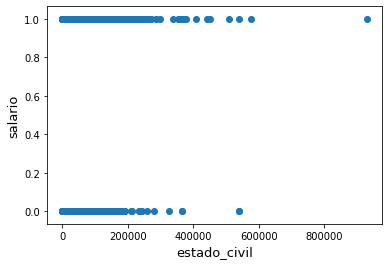

In [66]:
fig, ax = plt.subplots()
ax.scatter(x = df1['salario'], y = df1['estado_civil'])
plt.ylabel('salario', fontsize=13)
plt.xlabel('estado_civil', fontsize=13)
plt.show()

In [67]:
print("A média de salários para os Casados é de R$", df1[df1.estado_civil == 1]['salario'].mean())
print("O desvio padrão de salários para os Casados é de R$",df1[df1.estado_civil == 1]['salario'].std())

print("A média de salários para os Solteiros é de R$",df1[df1.estado_civil == 0]['salario'].mean())
print("A desvio padrão de salários para os Solteiros é de R$",df1[df1.estado_civil == 0]['salario'].std())

A média de salários para os Casados é de R$ 14454.942522282703
O desvio padrão de salários para os Casados é de R$ 23694.410729465733
A média de salários para os Solteiros é de R$ 10605.294510782656
A desvio padrão de salários para os Solteiros é de R$ 16689.781154857235


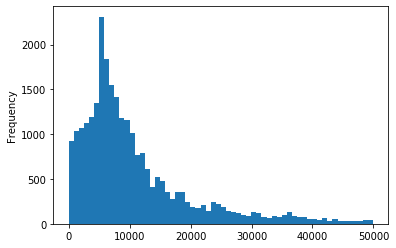

In [68]:
mask_salario = df1.salario<50000
mask_casado = df1.estado_civil == 1
mask_solteiro = df1.estado_civil == 0
df1[(mask_salario) & (mask_casado)]['salario'].plot.hist(bins=60)

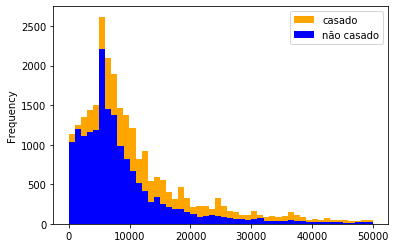

In [69]:
df1[(mask_salario) & (mask_casado)]['salario'].plot.hist(bins=50,color='orange',label='casado')
df1[(mask_salario) & (mask_solteiro)]['salario'].plot.hist(bins=50,color='blue',label='não casado')
plt.legend()
plt.show()

__Função LOG na variável salario - em todo o dataframe.__

In [70]:
df1['log_do_salario'] = np.log1p(df1['salario'])

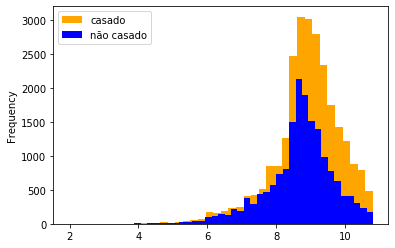

In [72]:
df1[(mask_salario) & (mask_casado)]['log_do_salario'].plot.hist(bins=40,color='orange',label='casado')
df1[(mask_salario) & (mask_solteiro)]['log_do_salario'].plot.hist(bins=40,color='blue',label='não casado')
plt.legend()
plt.show()

In [80]:
run_regression(df1,'salario ~ idade + C(estado_civil)')

                      Results: Ordinary least squares
Model:                 OLS                Adj. R-squared:       0.021       
Dependent Variable:    salario            AIC:                  1013885.0737
Date:                  2019-06-24 11:53   BIC:                  1013911.1881
No. Observations:      44569              Log-Likelihood:       -5.0694e+05 
Df Model:              2                  F-statistic:          482.2       
Df Residuals:          44566              Prob (F-statistic):   6.28e-208   
R-squared:             0.021              Scale:                4.4373e+08  
----------------------------------------------------------------------------
                         Coef.   Std.Err.    t    P>|t|    [0.025    0.975] 
----------------------------------------------------------------------------
Intercept              2587.8528 361.6592  7.1555 0.0000 1878.9946 3296.7110
C(estado_civil)[T.1.0] 2560.5018 210.7173 12.1514 0.0000 2147.4923 2973.5112
idade                 

In [79]:
run_regression(df1,'log_do_salario ~ idade + C(estado_civil)')

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.024      
Dependent Variable: log_do_salario   AIC:                132292.0869
Date:               2019-06-24 11:50 BIC:                132318.2013
No. Observations:   44569            Log-Likelihood:     -66143.    
Df Model:           2                F-statistic:        560.1      
Df Residuals:       44566            Prob (F-statistic): 5.87e-241  
R-squared:          0.025            Scale:              1.1392     
--------------------------------------------------------------------
                       Coef.  Std.Err.    t     P>|t|  [0.025 0.975]
--------------------------------------------------------------------
Intercept              8.3775   0.0183 457.1664 0.0000 8.3416 8.4134
C(estado_civil)[T.1.0] 0.2001   0.0107  18.7460 0.0000 0.1792 0.2211
idade                  0.0108   0.0005  22.2126 0.0000 0.0098 0.0117
-----------------------------------------------------

__Observações:__
<br>
R2 em 0.024
O salário normalizado LOG explica melhor a variação de salário com as variáveis estado civil e idade, mas ainda é um valor baixo.
<br>
O estado civil 1 (casado) tem impacto positivo de 0,2 nos salários e a idade 0.01 (para este estado civil).
<br>
O P>|t| é igual a 0 para ambas as variáveis, portanto, elas são relevantes nesta amostra.

# 3 - Vale a pena estudar mais para ganhar salários maiores?

# Aplicando algumas Regressões Múltiplas

In [73]:
function1 = '''log_do_salario ~ idade + anos_estudo + estado_civil'''

model1 = smf.ols(function1, df1).fit() 

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:         log_do_salario   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     3224.
Date:                Mon, 24 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:40:41   Log-Likelihood:                -61859.
No. Observations:               44243   AIC:                         1.237e+05
Df Residuals:                   44239   BIC:                         1.238e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.9252      0.023    298.562   

__Observações:__
<br>
O R2 está em 0,179, ou seja, 17% da variação do salário é explicado pelas variáveis idade, anos de estudo e estado civil.

In [74]:
df1.sexo.value_counts()

homem       26481
mulher      18065
gestante       23
Name: sexo, dtype: int64

In [76]:
function1 = '''log_do_salario ~ idade + anos_estudo + estado_civil + C(sexo)'''

model1 = smf.ols(function1, df1[df1.sexo!='gestante']).fit() #

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:         log_do_salario   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     3620.
Date:                Mon, 24 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:43:11   Log-Likelihood:                -59930.
No. Observations:               44220   AIC:                         1.199e+05
Df Residuals:                   44215   BIC:                         1.199e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.0458      0.02

In [84]:
run_regression(df1,'log_do_salario ~ sexo + estado_civil + anos_estudo + idade + C(regiao)')

                   Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     0.255      
Dependent Variable:   log_do_salario   AIC:                119461.8492
Date:                 2019-06-24 12:00 BIC:                119548.8237
No. Observations:     44243            Log-Likelihood:     -59721.    
Df Model:             9                F-statistic:        1682.      
Df Residuals:         44233            Prob (F-statistic): 0.00       
R-squared:            0.255            Scale:              0.87112    
----------------------------------------------------------------------
                       Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------
Intercept              6.6657   0.1954  34.1209 0.0000  6.2828  7.0486
sexo[T.homem]          0.5033   0.1948   2.5832 0.0098  0.1214  0.8851
sexo[T.mulher]        -0.0793   0.1949  -0.4071 0.6839 -0.4614  0.3027
C(regiao)[T.nordeste]  0.9

__Observações:__
<br>
Há impactos negativos na variação do salário de acordo com algumas regiões. 
<br>
O gênero feminimo apresenta um P>|t| maior que 0,5, não sendo, portanto, relevante nesta amostra.